# Supplement 1

Analysis of human visual experience data

Johannes Zauner [](https://orcid.org/0000-0003-2171-4566) (Technical University of Munich, Germany, Max Planck Institute for Biological Cybernetics, Tübingen, Germany)  
Aaron Nicholls [](https://orcid.org/0009-0001-6683-6826) (Meta Reality Labs Research)  
Lisa A. Ostrin [](https://orcid.org/0000-0001-8675-1478) (University of Houston, Texas, USA)  
Manuel Spitschan [](https://orcid.org/0000-0002-8572-9268) (Technical University of Munich, Germany, Max Planck Institute for Biological Cybernetics, Tübingen, Germany, Technical University of Munich Institute of advanced study (TUM-IAS), Munich, Germany)  
July 29, 2025

> **Warning**
>
> Please note that this supplement is not in its final styling form, as it necessarily has to be formatted as a `notebook` to enable commenting. Current issues include:
>
> -   Cross-references not working (e.g. Figure labeling and referencing figures)
>
> These issues will be resolved when all comments have been gathered and implemented

## Abstract

This supplementary document provides a detailed, step-by-step tutorial on importing and preprocessing raw data from two wearable devices: `Clouclip` and `VEET`. We describe the structure of the raw datasets recorded by each device and explain how to parse these data, specify time zones, handle special sentinel values, clean missing observations, regularize timestamps to fixed intervals, and aggregate data as needed. All original R code from the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/) is preserved here for transparency, with additional guidance intended for a broad research audience. We demonstrate how to detect gaps and irregular sampling, convert implicit missing periods into explicit missing values, and address device-specific quirks such as the `Clouclip`’s use of sentinel codes for “sleep mode” and “out of range” readings. Special procedures for processing the `VEET`’s rich spectral data (e.g. normalizing sensor counts and reconstructing full spectra from multiple sensor channels) are also outlined. Finally, we show how to save the cleaned datasets from both devices into a single R data file for downstream analysis. This comprehensive walkthrough is designed to ensure reproducibility and to assist researchers in understanding and adapting the data pipeline for their own visual experience datasets.

## Introduction

Wearable sensors like the Clouclip and the Visual Environment Evaluation Tool (VEET) produce high-dimensional time-series data on viewing distance and light exposure. Proper handling of these raw data is essential before any analysis of visual experience metrics. In the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/), we introduced an analysis pipeline using the open-source R package LightLogR ([Zauner, Hartmeyer, and Spitschan 2025](#ref-Zauner2025JOpenSourceSoftw)) to calculate various distance and light exposure metrics. Here, we present a full account of the data import and preparation steps as a supplement to the methods, with an emphasis on clarity for researchers who may be less familiar with data processing in R.

We use example datasets from a `Clouclip` device ([Wen et al. 2021](#ref-Wen2021ActaOphtalmol), [2020](#ref-Wen2020bjophthalmol)) and from a `VEET` device ([Sah, Narra, and Ostrin 2025](#ref-Sah2025OphtalmicPhysiolOpt)) (both provided in the accompanying [repository](https://github.com/tscnlab/ZaunerEtAl_2025_JOV)). The `Clouclip` is a glasses-mounted sensor that records working distance (distance from eyes to object, in cm) and ambient illuminance (in lux) at 5-second intervals. The `VEET` is a head-mounted multi-modal sensor that logs ambient light and spectral information (along with other data like motion and distance via a depth sensor) - in this exemplary case at 2-second intervals. A single week of continuous data illustrates the contrast in complexity: approximately 1.6 MB for the `Clouclip`’s simple two-column output versus up to 270 MB for the `VEET`’s multi-channel output (due to its higher sampling rate and richer sensor modalities).

In the following sections, we detail how these raw data are structured and how to import and preprocess them using LightLogR. We cover device-specific considerations such as file format quirks and sensor range limitations, as well as general best practices like handling missing timestamps and normalizing sensor readings. All code blocks can be executed in R (with the required packages loaded) to reproduce the cleaning steps. The end result will be clean, regularized datasets (`dataCC` for Clouclip, `dataVEET` for VEET light data, and `dataVEET2` for VEET spectral data) ready for calculating visual experience metrics. We conclude by saving these cleaned datasets into a single file for convenient reuse.

## `Clouclip` Data: Raw Structure and Import

The `Clouclip` device exports its data as a text file (not a true Excel file despite sometimes using an .xls extension), which is actually tab-separated values. Each record corresponds to one timestamped observation (nominally every 5 seconds) and includes two measured variables: **distance** and **illuminance**. In the sample dataset (`Sample_Clouclip.csv` provided), the columns are:

-   `Date` – the date and time of the observation (in the device’s local time, here one week in 2021).

-   `Dis` – the viewing distance in centimeters.

-   `Lux` – the ambient illuminance in lux.

For example, a raw data line might look like:

    2021-07-01 08:00:00 45  320

indicating that at *2021-07-01 08:00:00* local time, the device recorded a working distance of 45 cm and illuminance of 320 lx. The Clouclip uses special **sentinel values**[1] in these measurement columns to denote certain device states. Specifically, a distance (`Dis`) value of **204** is a code meaning the object is *out of the sensor’s range*, and a value of **-1** in either `Dis` or `Lux` indicates the device was in *sleep mode* (not actively recording). During normal operation, distance measurements are limited by the device’s range, and illuminance readings are positive lux values. Any sentinel codes in the raw file need to be handled appropriately, as described below.

We will use LightLogR’s built-in import function for `Clouclip`, which automatically reads the file, parses the timestamps, and converts sentinel codes into a separate status annotation. To begin, we load the necessary libraries and import the raw `Clouclip` dataset:

[1] A *sentinel value* is a special placeholder value used in data recording to signal a particular condition. It does not represent a valid measured quantity but rather acts as a marker (for example, “device off” or “value out of range”).

In [ ]:
# Load required packages
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Successfully read in 58'081 observations across 1 Ids from 1 Clouclip-file(s).
Timezone set is US/Central.
The system timezone is UTC. Please correct if necessary!

First Observation: 2021-02-06 17:12:47
Last Observation: 2021-02-14 17:12:36
Timespan: 8 days

Observation intervals: 
  Id       interval.time            n pct     
1 Clouclip 5s                   54572 93.9601%
2 Clouclip 17s                     12 0.0207% 
3 Clouclip 18s                     14 0.0241% 
4 Clouclip 120s (~2 minutes)     3479 5.9900% 
5 Clouclip 128s (~2.13 minutes)     1 0.0017% 
6 Clouclip 132s (~2.2 minutes)      1 0.0017% 
7 Clouclip 133s (~2.22 minutes)     1 0.0017% 

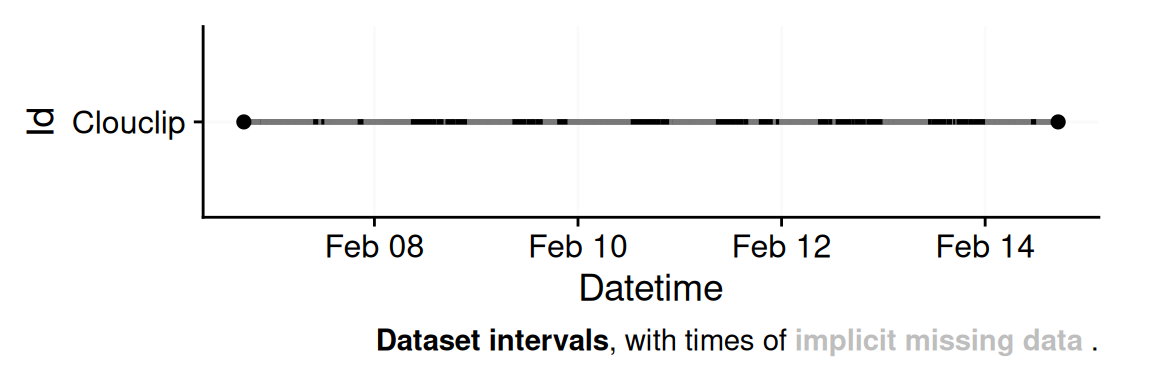

In [ ]:
# Define file path and time zone
path <- "data/Sample_Clouclip.csv"
tz   <- "US/Central"   # Time zone in which device was recording (e.g., US Central Time)
# Import Clouclip data
dataCC <- import$Clouclip(path, tz = tz, manual.id = "Clouclip")


In this code, `import$Clouclip()` reads the tab-delimited file and returns a **tibble**[1] (saved in the variable `dataCC`) containing the data. We specify `tz = "US/Central"` because the device’s clock was set to U.S. Central time; this ensures that the `Datetime`values are properly interpreted with the correct time zone. The argument `manual.id = "Clouclip"` simply tags the dataset with an identifier (useful if combining data from multiple devices).

During import, LightLogR automatically handles the `Clouclip`’s sentinel codes. The `Date` column from the raw file is parsed into a POSIX date-time (`Datetime`) with the specified time zone. The `Lux` and `Dis` columns are read as numeric, but any occurrences of **-1** or **204** are treated specially: these are replaced with `NA` (missing values) in the numeric columns, and corresponding status columns `Lux_status` and `Dis_status` are created to indicate the reason for those `NA` values. For example, if a `Dis` value of 204 was encountered, that row’s `Dis` will be set to NA and `Dis_status` will contain `"out_of_range"`; if `Lux` or `Dis` was -1, the status is `"sleep_mode"`. We will set all other readings to  `"operational"` (meaning the device was functioning normally at that time) for visualisation purposes.

After import, it is good practice to get an overview of the data. The import function by default prints a brief summary (and generates an overview plot of the timeline) showing the number of observations, the time span, and any irregularities or large gaps. In our case, the `Clouclip` summary indicates the data spans one week and reveals that there are **irregular intervals** in the timestamps. This means some observations do not occur exactly every 5 seconds as expected. We can programmatically check for irregular timing:

[1] **tibble** are data.tables with tweaked behavior, ideal for a tidy analysis workflow. For more information, visit the documentation page for [tibbles](https://tibble.tidyverse.org/index.html)

In [ ]:
# Check if data are on a perfectly regular 5-second schedule
dataCC |> has_irregulars()


[1] TRUE

If the result is `TRUE`, it confirms that the time sequence has deviations from the 5-second interval. Indeed, our example dataset has many small timing irregularities and gaps (periods with no data). Understanding the pattern of these missing or irregular readings is important. We can visualize them using a gap plot:

(`geom_line()`).

(`geom_point()`).

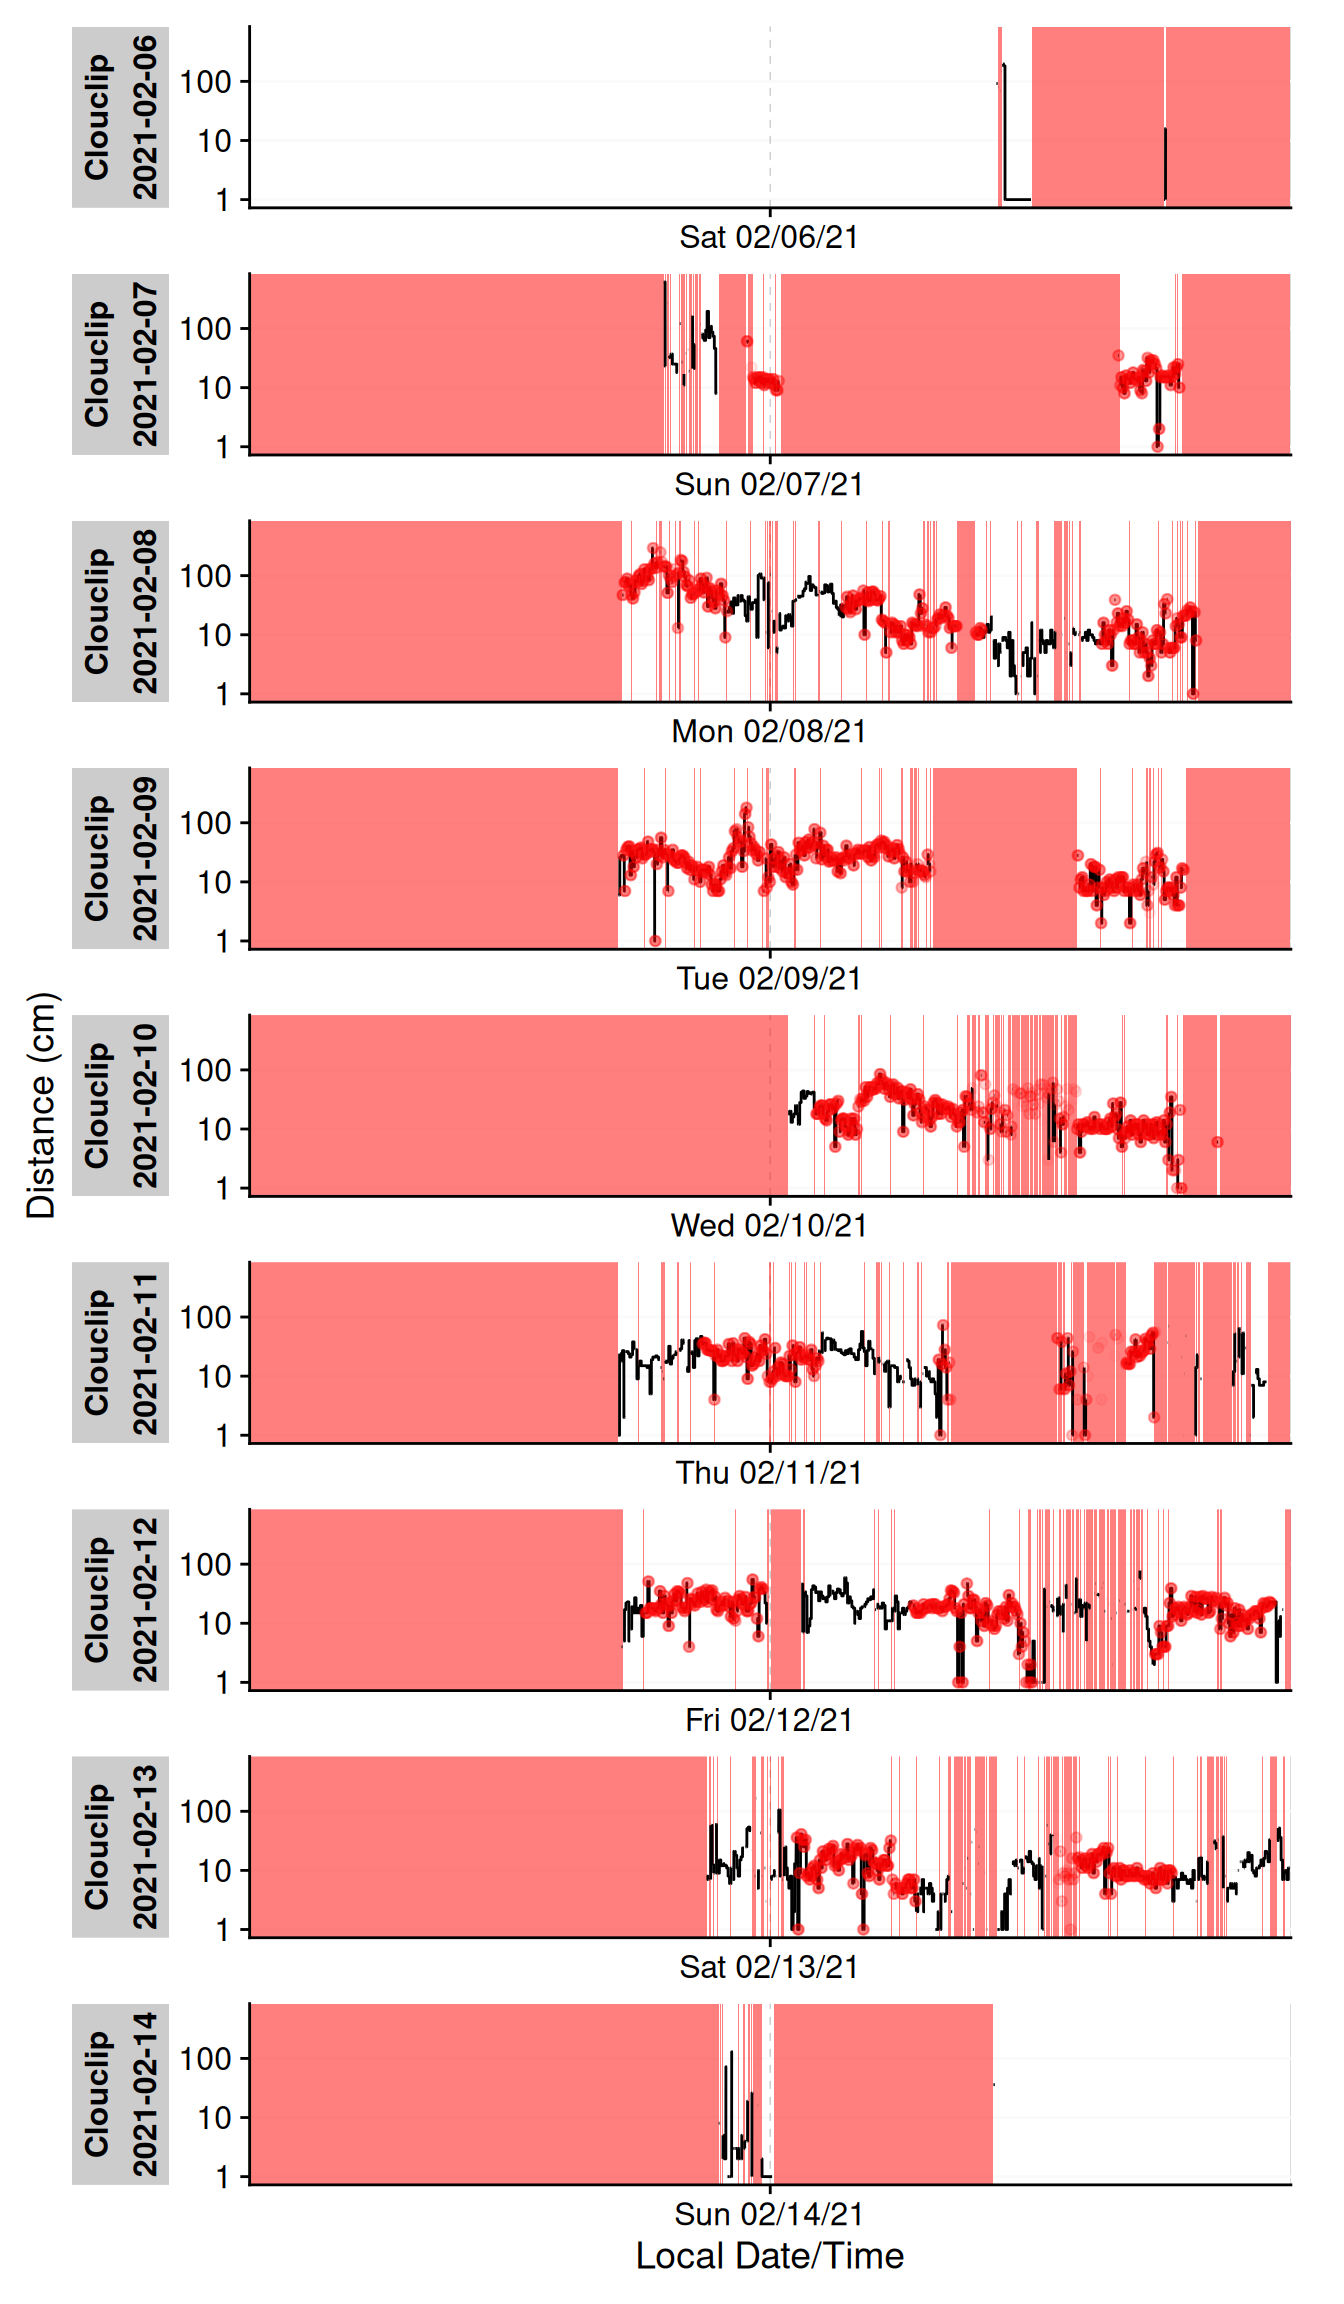

In [ ]:
# Plot gaps and irregular timestamps for Clouclip data
y.label <- "Distance (cm)"
dataCC |> gg_gaps(Dis, 
                  include.implicit.gaps = FALSE,  # only show recorded gaps, not every missing point
                  show.irregulars = TRUE,         # highlight irregular timing
                  y.axis.label = y.label,
                  group.by.days = TRUE, col.irregular = alpha("red", 0.03)
                  ) + labs(title = NULL)


In ([**fig-irregular?**](#ref-fig-irregular)), time periods where data are missing appear as red-shaded areas, and any off-schedule observation times are marked with red dots. The `Clouclip` example shows extensive gaps (red blocks) on certain days and irregular timing on all days except the first and last. These irregular timestamps likely arise from the device’s logging process (e.g. slight clock drift or buffering when the device was turned on/off). Such issues must be addressed before further analysis.

When faced with irregular or gapped data, LightLogR recommends a few strategies:

-   *Remove leading/trailing segments that cause irregularity.* For example, if only the first day is regular and subsequent days drift, one might exclude the problematic portion using date filters (see [filter_Date() / filter_Datetime()](https://tscnlab.github.io/LightLogR/reference/filter_Datetime.html) in LightLogR).

-   *Round timestamps to the nearest regular interval.* This can snap slightly off-schedule times back to the 5-second grid (using [cut_Datetime()](https://tscnlab.github.io/LightLogR/reference/cut_Datetime.html) with a 5-second interval), provided the deviations are small and this rounding won’t create duplicate timestamps.

-   *Aggregate to a coarser time interval.* For instance, grouping data into 1-minute bins with [aggregate_Datetime()](https://tscnlab.github.io/LightLogR/reference/aggregate_Datetime.html) can mask irregularities at finer scales, at the cost of some temporal resolution.

In this case, the deviations from the 5-second schedule are relatively minor. We choose to **round the timestamps to the nearest 5 seconds** to enforce a uniform sampling grid, which simplifies downstream gap handling. We further add a separate date column for convenience:

In [ ]:
# Regularize timestamps by rounding to nearest 5-second interval
dataCC <- dataCC |>
  cut_Datetime("5 secs", New.colname = Datetime) |>  # round times to 5-second bins
  add_Date_col(group.by = TRUE)                     # add a Date column for grouping by day


After this operation, all `Datetime` entries in `dataCC` align perfectly on 5-second boundaries (e.g. **08:00:00**, **08:00:05**, **08:00:10**, etc.). We can verify that no irregular intervals remain by re-running `has_irregulars()` (it now returns `FALSE`). Next, we want to quantify the missing data. LightLogR distinguishes between **explicit missing values** (actual `NA`s in the data, possibly from sentinel replacements or gaps we have filled in) and **implicit missing intervals** (time points where the device *should* have a reading but none was recorded, and we have not yet filled them in). Initially, many gaps are still implicit (between the first and last timestamp of each day). We can generate a gap summary table:

In [ ]:
# Summarize observed vs missing data by day for distance
dataCC |> gap_table(Dis, Variable.label = "Distance (cm)") |>
  cols_hide(contains("_n"))   # hide absolute counts for brevity in output


This summary (([**tbl-gaps?**](#ref-tbl-gaps))) breaks down, for each day, how much data is present vs. missing. It reports the total duration of recorded data and the duration of gaps. After rounding the times, there are no irregular timestamp issues, but we see substantial **implicit gaps** — periods where the device was not recording (e.g., overnight when the device was likely not worn or was in sleep mode). Notably, the first and last days of the week have very little data (less than 1 hour each), since they probably represent partial recording days (the device was put on and removed on those days).

To prepare the dataset for analysis, we will convert all those implicit gaps into explicit missing entries, and remove days that are mostly incomplete. Converting implicit gaps means inserting rows with `NA` for each missing 5-second slot, so that the time series becomes continuous and explicit about missingness. We use `gap_handler()` for this, and then drop the nearly-empty days:

In [ ]:
# Convert implicit gaps to explicit NA gaps, and drop days with <1 hour of data
dataCC <- dataCC |> 
  # First ensure that status columns have an "operational" tag for non-missing periods:
  mutate(across(c(Lux_status, Dis_status), ~ replace_na(.x, "operational"))) |> 
  # Fill in all implicit gaps with explicit NA rows (for full days range):
  gap_handler(full.days = TRUE) |>  
  # Remove any day that has less than 1 hour of recorded data
  remove_partial_data(Dis, threshold.missing = "23 hours")


After these steps, `dataCC` contains continuous 5-second timestamps for each day that remains. We chose a threshold of “23 hours” missing to remove days with \<1 hour of data, which in this dataset removes the first and last (partial) days. The cleaned `Clouclip` data now covers six full days with bouts of continuous wear.

It is often helpful to double-check how the sentinel values and missing data are distributed over time. We can visualize the distance time-series with status annotations and day/night periods:

(`geom_line()`).

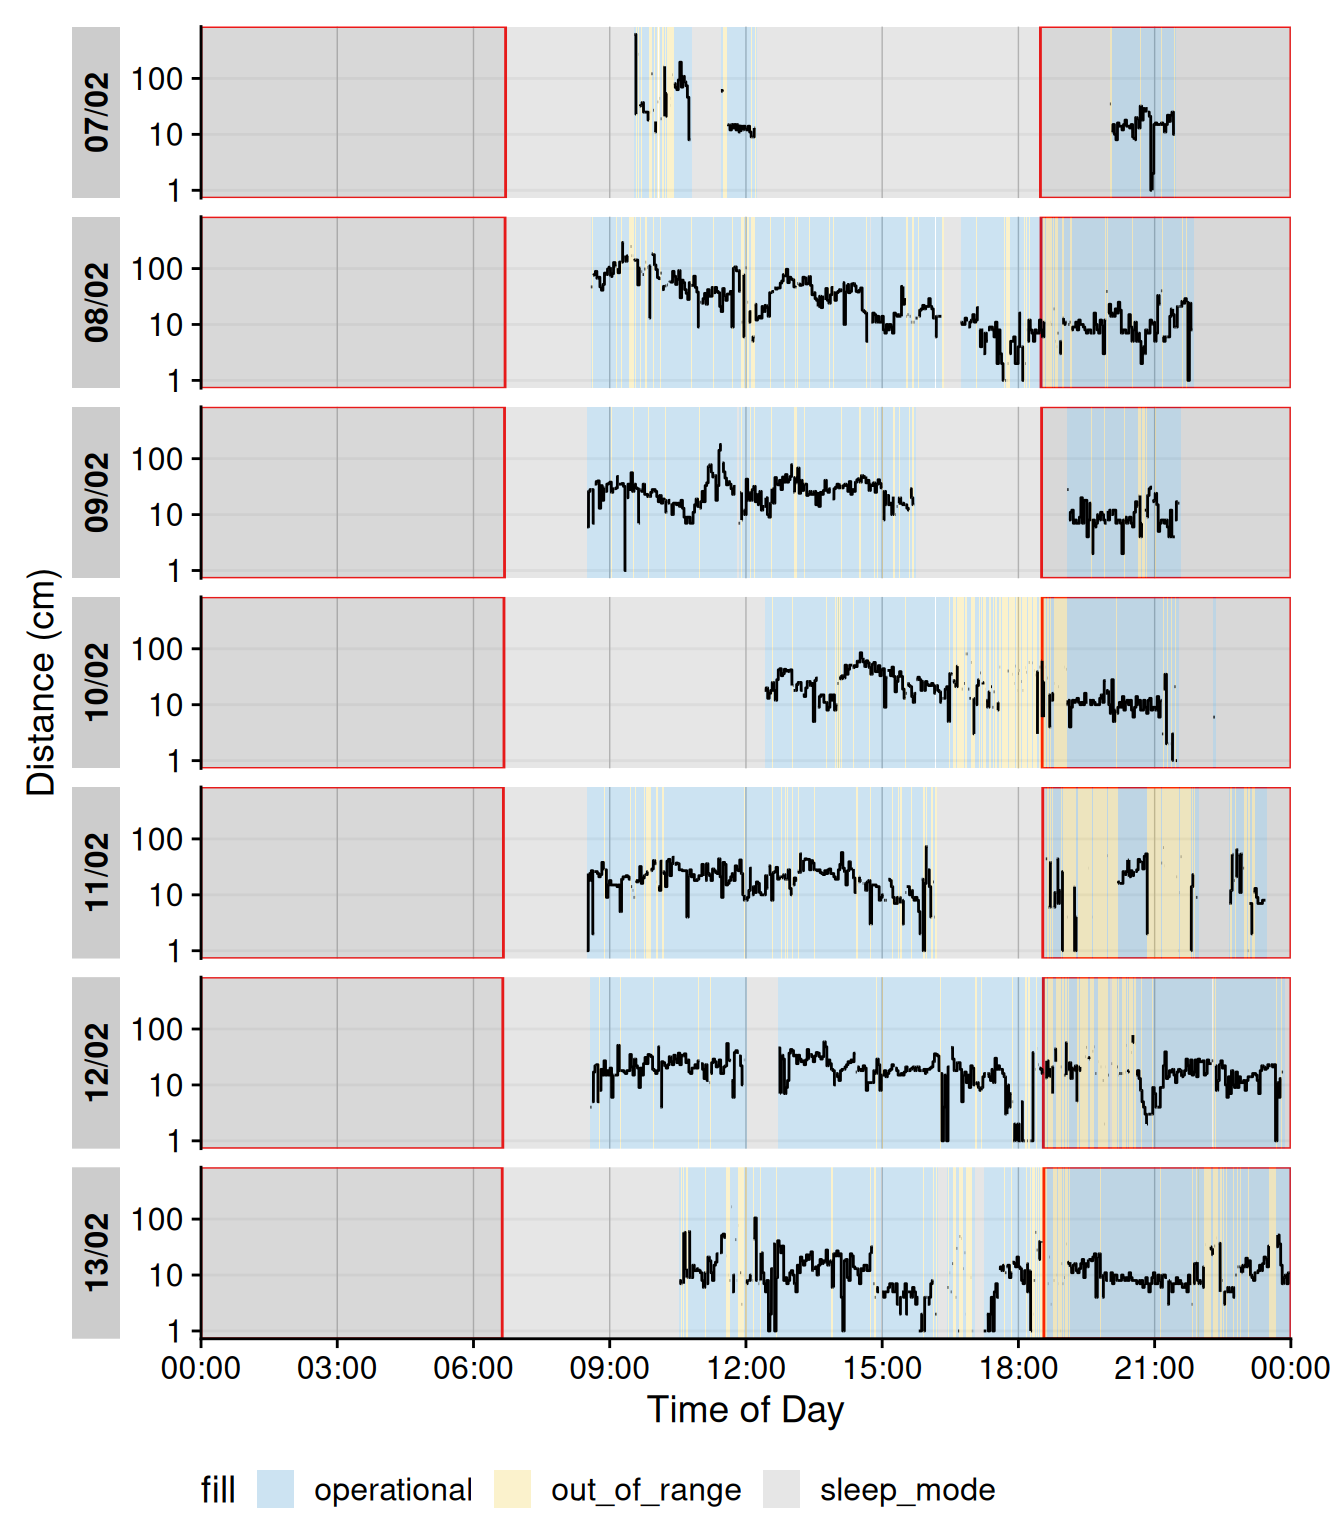

In [ ]:
#setting coordinates for Houston, Texas
coordinates <- c(29.75, -95.36)
# visualize observations
dataCC |> 
  fill(c(Lux_status, Dis_status), .direction = "downup") |> 
  gg_day(y.axis = Dis, geom = "line", y.axis.label = y.label) |> #create a basic plot
  gg_state(Dis_status, aes_fill = Dis_status) |> #add the status times
  gg_photoperiod(coordinates, alpha = 0.1, col = "red") + #add the photoperiod (day/night)
  theme(legend.position = "bottom")


In this plot, blue segments indicate times when the Clouclip was *operational* (actively measuring), grey segments indicate the device in *sleep mode* (no recording, typically at night), and yellow segments indicate *out-of-range* distance readings. The red outlined regions show nighttime (from civil dusk to dawn) based on the given latitude/longitude and dates. As expected, most of the grey “sleep” periods align with night hours, and we see a few yellow spans when the user’s viewing distance exceeded the device’s range (e.g. presumably when no object was within 100 cm, such as when the user looked into the distance). At this stage, the Clouclip dataset `dataCC` is fully preprocessed: all timestamps are regular 5-second intervals, missing data are explicitly marked, extraneous partial days are removed, and sentinel codes are handled via the status columns. The data are ready for calculating daily distance and light exposure metrics (as done in the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/)’s Results).

## `VEET` Data: Ambient Light (Illuminance) Processing

The **VEET** device ([Sah, Narra, and Ostrin 2025](#ref-Sah2025OphtalmicPhysiolOpt)) is a more complex logger that records multiple data modalities in one combined file. Its raw data file contains interleaved records for different sensor types, distinguished by a “modality” field. We focus first on the ambient light sensor modality (abbreviated **ALS**), which provides broad-spectrum illuminance readings (lux) and related information like sensor gains and flicker, recorded every 2 seconds. Later we will import the spectral sensor modality (**PHO**) for spectral irradiance data.

In the `VEET`’s export file, each line includes a timestamp and a modality code, followed by fields specific to that modality. Importantly, this means that the `VEET` export is not rectangular, i.e., tabular. This makes it challenging for many import functions that expect the equal number of columns in every row, which is not the case in this instance. For the **ALS modality**, the relevant columns include a high-resolution timestamp (in Unix epoch format), integration time, UV/VIS/IR sensor gain settings, raw UV/VIS/IR sensor counts, a flicker measurement, and the computed illuminance in lux. For example, the ALS data columns are named: `time_stamp`, `integration_time`, `uvGain`, `visGain`, `irGain`, `uvValue`, `visValue`, `irValue`, `Flicker`, and `Lux`.

For the **PHO (spectral) modality**, the columns include a timestamp, integration time, a general `Gain` factor, and nine sensor channel readings covering different wavelengths (with names like `s415, s445, ..., s680, s940`) as well as a `Dark` channel and two broadband channels `ClearL` and `ClearR`. In essence, the `VEET`’s spectral sensor captures light in several wavelength bands (from ~415 nm up to 940 nm, plus an infrared and two “clear” channels) rather than outputting a single lux value like the ambient light sensor does (*PHO*).

To import the `VEET` ambient light data, we again use the LightLogR import function, specifying the `ALS` modality. The raw VEET data in our example is provided as a zip file (`01_VEET_L.csv.zip`) containing the logged data for one week. We do the following:

Multiple files in zip: reading '01_VEET_L.csv'

ℹ In argument: `dplyr::across(...)`.
Caused by warning:
! NAs introduced by coercion


Successfully read in 304'193 observations across 1 Ids from 1 VEET-file(s).
Timezone set is US/Central.
The system timezone is UTC. Please correct if necessary!
1 observations were dropped due to a missing or non-parseable Datetime value (e.g., non-valid timestamps during DST jumps). 

First Observation: 2024-06-04 15:00:37
Last Observation: 2024-06-12 08:29:43
Timespan: 7.7 days

Observation intervals: 
  Id    interval.time              n pct      
1 VEET  0s                         1 0.00033% 
2 VEET  1s                      1957 0.64334% 
3 VEET  2s                    300147 98.67025%
4 VEET  3s                      2074 0.68181% 
5 VEET  4s                         3 0.00099% 
6 VEET  9s                         5 0.00164% 
7 VEET  10s                        3 0.00099% 
8 VEET  109s (~1.82 minutes)       1 0.00033% 
9 VEET  59077s (~16.41 hours)      1 0.00033% 

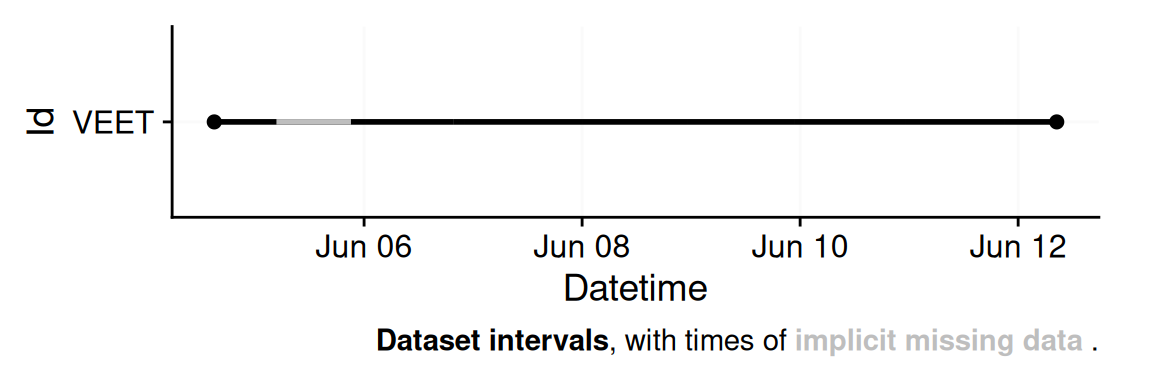

In [ ]:
# Import VEET Ambient Light Sensor (ALS) data
path <- "data/01_VEET_L.csv.zip"
tz   <- "US/Central"    # assuming device clock was set to US Central, for consistency
dataVEET <- import$VEET(path, tz = tz, modality = "ALS", manual.id = "VEET")


> **Note**
>
> We get one warning as a single time stamp could not be parsed into a datetime - with ~300k observations, this is not an issue.

This call reads in only the lines corresponding to the `ALS` modality from the `VEET` file. The result `dataVEET` is a tibble[1] with columns such as `Datetime` (parsed from the `time_stamp` epoch to POSIXct in US/Central time), `Lux` (illuminance in lux), `Flicker`, and the various sensor gains/values. Unneeded columns like the modality code or file name are also included but can be ignored or removed. After import, LightLogR again provides an overview of the data. We learn that the `VEET` light data, like the `Clouclip`, also exhibits irregularities and gaps. (The device nominally records every 2 seconds, but timing may drift or pause when not worn.)

To make the VEET light data comparable to the Clouclip’s and to simplify analysis, we choose to **aggregate the VEET illuminance data to 5-second intervals**. This slight downsampling will both reduce data volume and help align with the Clouclip’s timeline for any combined analysis. Before aggregation, we will also explicitly mark gaps in the VEET data so that missing intervals are not overlooked.

[1] **tibble** are data.tables with tweaked behavior, ideal for a tidy analysis workflow. For more information, visit the documentation page for [tibbles](https://tibble.tidyverse.org/index.html)

In [ ]:
# Aggregate VEET light data to 5-second intervals and mark gaps
dataVEET <- dataVEET |>
  aggregate_Datetime(unit = "5 seconds") |>  # resample to 5-sec bins (e.g. average Lux over 2-sec readings)
  gap_handler(full.days = TRUE) |>          # fill in implicit gaps with NA rows
  add_Date_col(group.by = TRUE) |>          # add Date column for daily grouping
  remove_partial_data(Lux, threshold.missing = "1 hour")


First, `aggregate_Datetime(unit = "5 seconds")` combines the high-frequency 2-second observations into 5-second slots. By default, this function will average numeric columns like `Lux` over each 5-second period (and handle counts or categorical appropriately). All of these *data type handlers* can be changed with the function call. The result is that `dataVEET` now has a reading every 5 seconds (or an NA if none were present in that window). Next, `gap_handler(full.days = TRUE)` inserts explicit NA entries for any 5-second timestamp that had no data within the continuous span of the recording. Then we add a `Date` column for grouping, and finally we remove days with more than 1 hour of missing data (using a more strict criterion as we did for `Clouclip`). According to the gap summary (([**tbl-gaps2?**](#ref-tbl-gaps2))), this leaves six full days of `VEET` light data with good coverage, after dropping the very incomplete start/end days.

We can inspect the missing-data summary for the `VEET` illuminance data:

In [ ]:
dataVEET |> gap_table(Lux, "Illuminance (lx)") |>   
  cols_hide(contains("_n")) #remove the absolute number of data points


([**tbl-gaps2?**](#ref-tbl-gaps2)) shows, for each retained day, the total recorded duration and the duration of gaps. The `VEET` device, like the `Clouclip`, was not worn continuously 24 hours per day, so there are nightly gaps of wear time (when the device was likely off the participant), but not of recordings. After our preprocessing, any implicit gaps are represented as explicit missing intervals. The `VEET`’s time sampling was originally more frequent, but by aggregating to 5 s we have ensured a uniform timeline akin to the `Clouclip`’s.

At this point, the `dataVEET` object (for illuminance) is cleaned and ready for computing light exposure metrics. For example, one could calculate daily mean illuminance or the duration spent above certain light thresholds (e.g. “outdoor light exposure” defined as \>1000 lx) using this dataset. Indeed, basic summary tables in the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/) illustrate the highly skewed nature of light exposure data and the calculation of outdoor light metrics. We will not repeat those metric calculations here in the supplement, as our focus is on data preprocessing; however, having a cleaned, gap-marked time series is crucial for those metrics to be accurate.

## `VEET` Data: Spectral Data Processing

### Import

In addition to broad-band illuminance, the `VEET` provides **spectral sensor data** through its `PHO` modality. Unlike illuminance, the spectral data are not directly given as directly interpretable radiometric metrics but rather as raw sensor counts across multiple wavelength channels, which require conversion to reconstruct a spectral power distribution. In our analysis, spectral data allow us to compute metrics like the relative contribution of short-wavelength (blue) light versus long-wavelength light in the participant’s environment. Processing this spectral data involves several necessary steps.

First, we import the spectral modality from a second `VEET` file. This device used the latest software version to allow for the best spectral reconstruction. This time we need to extract the lines marked as `PHO`. We will store the spectral dataset in a separate object `dataVEET2` so as not to overwrite the `dataVEET` illuminance data in our R session:

Multiple files in zip: reading '02_VEET_L.csv'


Successfully read in 173'013 observations across 1 Ids from 1 VEET-file(s).
Timezone set is US/Central.
The system timezone is UTC. Please correct if necessary!

First Observation: 2025-06-17 12:25:13
Last Observation: 2025-06-21 22:47:01
Timespan: 4.4 days

Observation intervals: 
   Id    interval.time      n pct      
 1 VEET  1s               417 0.24102% 
 2 VEET  2s            171837 99.32086%
 3 VEET  3s               738 0.42656% 
 4 VEET  4s                 7 0.00405% 
 5 VEET  9s                 1 0.00058% 
 6 VEET  11s                1 0.00058% 
 7 VEET  12s                2 0.00116% 
 8 VEET  13s                4 0.00231% 
 9 VEET  15s                1 0.00058% 
10 VEET  16s                1 0.00058% 
# ℹ 3 more rows

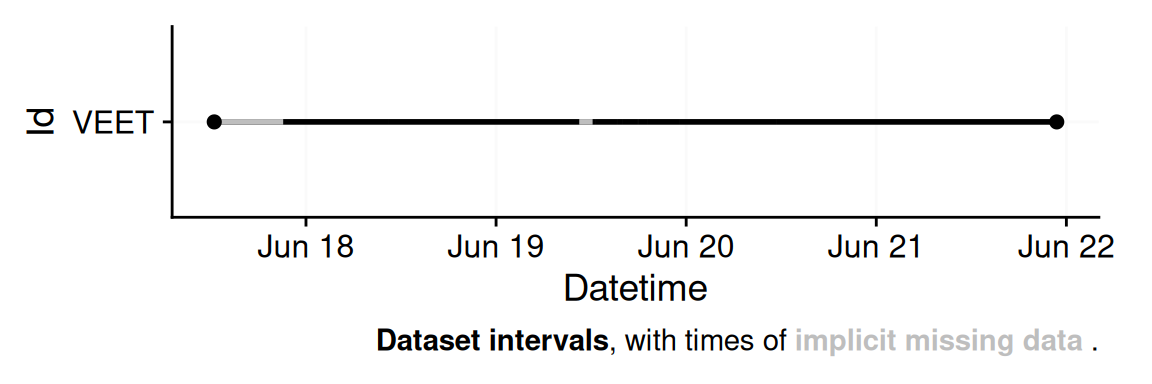

In [ ]:
# Import VEET Spectral Sensor (PHO) data
path <- "data/02_VEET_L.csv.zip"
#if a version of LightLogR ≤ 0.9.2 is used, this script needs to be imported, as the device data was collected with a newer firmware version that changes the output format.
source("scripts/VEET_import.R")
dataVEET2 <- import$VEET(path, tz = tz, modality = "PHO", manual.id = "VEET")


After import, `dataVEET2` contains columns for the timestamp (`Datetime`), `Gain` (the sensor gain setting), and the nine spectral sensor channels plus a clear channel. These appear as numeric columns named `s415, s445, ..., s940, Dark, Clear`. The spectral sensor was logging at a 2-second rate. Because this dataset is even denser and more high-dimensional, we will **aggregate it to a 5-minute interval** for computational efficiency. The assumption is that spectral composition does not need to be examined at every 2-second instant for our purposes, and 5-minute averages can capture the general trends while drastically reducing data size and downstream computational costs.

In [ ]:
# Aggregate spectral data to 5-minute intervals and mark gaps
dataVEET2 <- dataVEET2 |>
  aggregate_Datetime(unit = "5 mins") |>     # aggregate to 5-minute bins
  gap_handler(full.days = TRUE) |>           # explicit NA for any gaps in between
  add_Date_col(group.by = TRUE) |> 
  remove_partial_data(Clear, threshold.missing = "1 hour")


We aggregate over 5-minute windows; within each 5-minute bin, multiple spectral readings (if present) are combined (averaged). We use one of the channels (here `Clear`) as the reference variable for `remove_partial_data` to drop incomplete days (the choice of channel is arbitrary as all channels share the same level of completeness).

It is informative to look at a snippet of the imported spectral data before further processing. ([**tbl-PHO?**](#ref-tbl-PHO)) shows the first three rows of `dataVEET2` after import (before calibration), with some technical columns omitted for brevity:

In [ ]:
dataVEET2 |> head(3) |> select(-c(modality, file.name, is.implicit, time_stamp)) |> 
  gt() |> fmt_number(s415:Clear) 


### Spectral calibration

Now we proceed with **spectral calibration**. The `VEET`’s spectral sensor counts need to be converted to physical units (spectral irradiance) via a calibration matrix provided by the manufacturer. For this example, we assume we have a calibration matrix that maps all the channel readings to an estimated spectral power distribution (SPD). The LightLogR package provides a function `spectral_reconstruction()` to perform this conversion. However, before applying it, we must ensure the sensor counts are in a normalized form. This procedure is laid out by the manufacturer. In our version, we refer to the *VEET SPD Reconstruction Guide.pdf*, version *06/05/2025*. Note that each manufacturer has to specify the method of count normalization (if any) and spectral reconstruction. In our raw data, each observation comes with a `Gain` setting that indicates how the sensor’s sensitivity was adjusted; we need to divide the raw counts by the gain to get normalized counts. LightLogR offers `normalize_counts()` for this purpose. We further need to scale by integration time (in milliseconds) and adjust depending on counts in the `Dark` sensor channel.

In [ ]:
count.columns <- c("s415", "s445", "s480", "s515", "s555", "s590", "s630", 
                      "s680", "s910", "Dark", "Clear") #column names

gain.ratios <- #gain ratios as specified by the manufacturers reconstruction guide
  tibble(
    gain = c(0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512),
    gain.ratio = c(0.008, 0.016, 0.032, 0.065, 0.125, 0.25, 0.5, 1, 2, 3.95, 7.75)
  ) 

#normalize data
dataVEET2 <-
  dataVEET2 |> 
  mutate(across(c(s415:Clear), \(x) (x - Dark)/integration_time)) |>  #remove dark counts & scale by integration time
  normalize_counts( #function to normalize counts
    gain.columns = rep("Gain", 11), #all sensor channels share the gain value
    count.columns = count.columns, #sensor channels to normalize
    gain.ratios #gain ratios
  ) |> 
  select(-c(s415:Clear)) |> # drop original raw count columns
  rename_with(~ str_remove(.x, ".normalized"))


In this call, we specified `gain.columns = rep("Gain", 11)` because we have 11 sensor columns that all use the same gain factor column (`Gain`). This step will add new columns (with a suffix, e.g. `.normalized`) for each spectral channel representing the count normalized by the gain. We then dropped the `raw` count columns and renamed the normalized ones by dropping `.normalized` from the names. After this, `dataVEET2` contains the normalized sensor readings for `s415, s445, ..., s940, Dark, Clear` for each 5-minute time point. The dataset is now ready for spectral reconstruction.

### Spectral reconstruction

For spectral reconstruction, we require a calibration matrix that corresponds to the VEET’s sensor channels. This matrix would typically be obtained from the device manufacturer or a calibration procedure. It defines how each channel’s count relates to intensity at various wavelengths. For demonstration, the calibration matrix was provided by the manufacturer and is specific to the make and model. It should not be used for research purposes without confirming its accuracy with the manufacturer.

In [ ]:
#import calibration matrix
calib_mtx <- 
  read_csv("data/VEET_calibration_matrix.csv", show_col_types = FALSE) |> 
  column_to_rownames("wavelength")

# Reconstruct spectral power distribution (SPD) for each observation
dataVEET2 <- dataVEET2 |> mutate(
  Spectrum = spectral_reconstruction(
    pick(s415:s910),   # pick the normalized sensor columns
    calibration_matrix = calib_mtx, 
    format = "long" # return a long-form list column (wavelength, intensity)
  )
)


Here, we use `format = "long"` so that the result for each observation is a **list-column** `Spectrum`, where each entry is a tibble[1] containing two columns: `wavelength` and `irradiance` (one row per wavelength in the calibration matrix). In other words, each row of `dataVEET2` now holds a full reconstructed spectrum in the `Spectrum` column. The long format is convenient for further calculations and plotting. (An alternative `format = "wide"` would add each wavelength as a separate column, but that is less practical when there are many wavelengths.)

To visualize the data we will calculate the photopic illuminance based on the spectra and plot each spectrum color-scaled by their illuminance. For clarity, we reduce the data to observations within the first day.

[1] **tibble** are data.tables with tweaked behavior, ideal for a tidy analysis workflow. For more information, visit the documentation page for [tibbles](https://tibble.tidyverse.org/index.html)

(`geom_line()`).

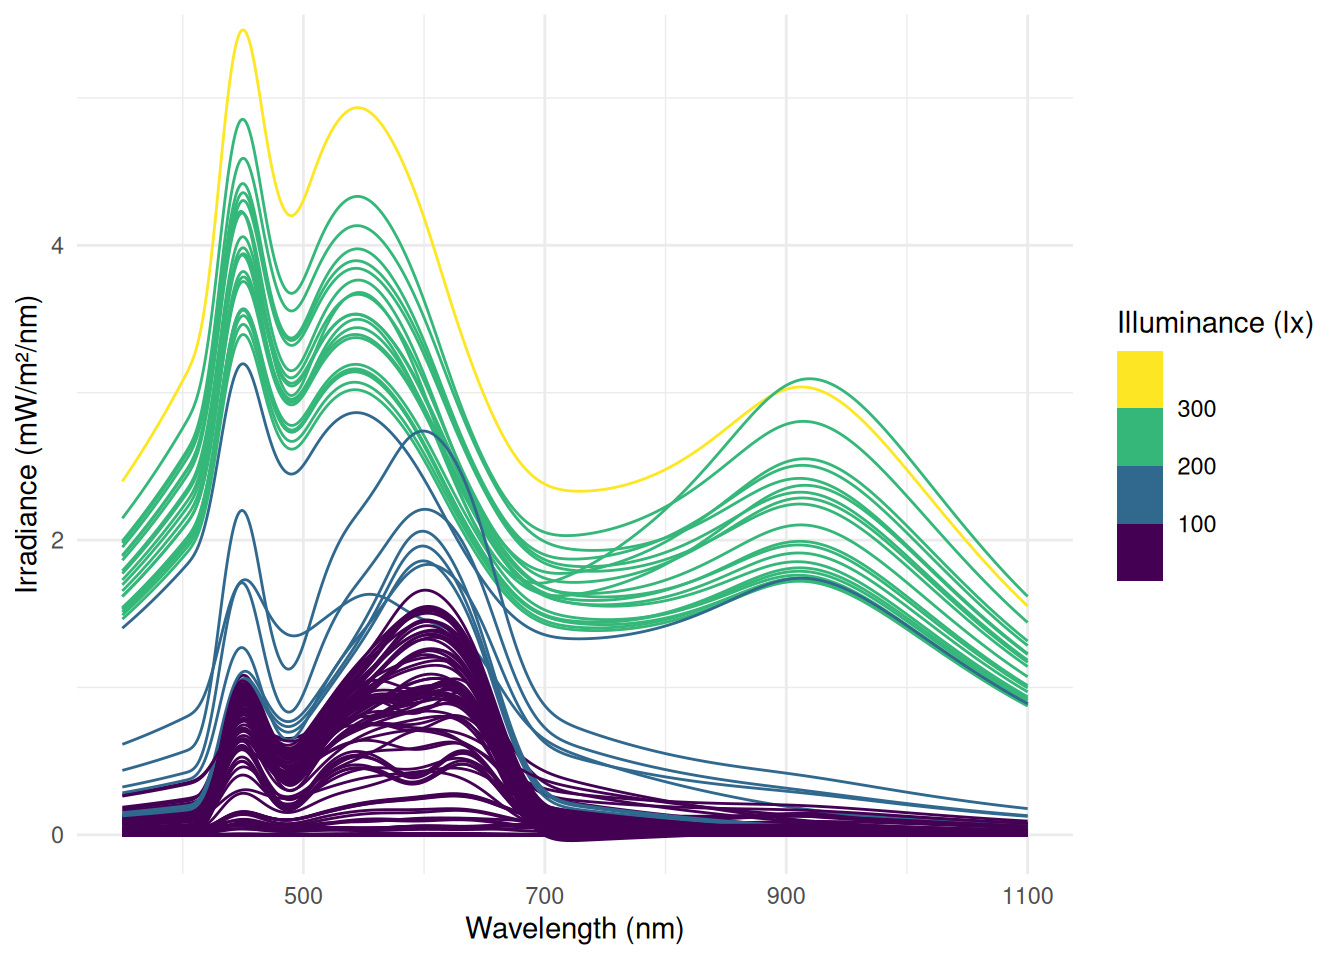

In [ ]:
dataVEET2 |> 
  filter_Date(length = "1 day") |> #keep only observations for one day (from start)
  mutate( 
    Illuminance = Spectrum |> #Use the spectrum,...
      map_dbl(spectral_integration, #... call the function spectral_integration for each,...
              action.spectrum = "photopic", #... use the brightness sensitivity function,...
              general.weight = "auto") #... and apply the appropriate efficacy weight.
  ) |> 
  unnest(Spectrum) |> #create a long format of the data where the spectrum is unnested
  ggplot(aes(x = wavelength, y = irradiance*1000, group = Datetime)) +
  geom_line(aes(col = Illuminance)) +
  labs(y = "Irradiance (mW/m²/nm)", x = "Wavelength (nm)", col = "Illuminance (lx)")+
  scale_color_viridis_b() +
  coord_cartesian(ylim = c(0,5.3)) +
  theme_minimal()


At this stage, the `dataVEET2` dataset has been processed to yield time-series of spectral power distributions. We can use these to compute biologically relevant light metrics. For instance, one possible metric is the proportion of power in short wavelengths versus long wavelengths. In the main analysis, we defined **short-wavelength (blue light) content** as the integrated intensity in the 400–500 nm range, and **long-wavelength content** as the integrated intensity in a longer range (e.g. 600–700 nm), then computed the *short-to-long ratio* (“sl ratio”). Calculating these metrics is the first step of spectrum analysis in the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/#spectrum).

    dataVEET2 |> 
      select(Id, Date, Datetime, Spectrum) |>    # focus on ID, date, time, and spectrum
      mutate(
        short = Spectrum |> map_dbl(spectral_integration, wavelength.range = c(400, 500)),
        long  = Spectrum |> map_dbl(spectral_integration, wavelength.range = c(600, 700)),
        `sl ratio` = short / long   # compute short-to-long ratio
      )

*(The cutoff of 500 nm here is hypothetical for demonstration; actual definitions might vary.)* We would then have columns `short`, `long`, and `sl_ratio` for each observation, which could be averaged per day or analyzed further. The cleaned spectral data in `dataVEET2` makes it straightforward to calculate such metrics or apply spectral weighting functions (for melatonin suppression, circadian stimulus, etc., if one has the spectral sensitivity curves).

With the `VEET` spectral preprocessing complete, we emphasize that these steps – normaliziing by gain, applying calibration, and perhaps simplifying channels – are **device-specific** requirements. They ensure that the raw sensor counts are translated into meaningful physical measures (like spectral irradiance). Researchers using other spectral devices would follow a similar procedure, adjusting for their device’s particulars (some may output spectra directly, whereas others, like `VEET`, require reconstruction.

> **Note**
>
> Some devices may output normalized counts instead of raw counts. For example, the `ActLumus` device outputs normalized counts, while the `VEET` device records raw counts and the gain. Manufacturers will be able to speficy exact outputs for a given model and software version.

## Saving the Cleaned Data

After executing all the above steps, we have three cleaned data frames in our R session:

-   **`dataCC`** – the processed `Clouclip` dataset (5-second intervals, with distance and lux, including NA for gaps and sentinel statuses).

-   **`dataVEET`** – the processed `VEET` ambient light dataset (5-second intervals, illuminance in lux, with gaps filled).

-   **`dataVEET2`** – the processed `VEET` spectral dataset (5-minute intervals, each entry containing a spectrum or derived spectral metrics).

For convenience and future reproducibility, we will save these combined results to a single R data file. Storing all cleaned data together ensures that any analysis can reload the exact same data state without re-running the import and cleaning (which can be time-consuming for large raw files).

In [ ]:
# Create directory for cleaned data if it doesn't exist
if (!dir.exists("data/cleaned")) dir.create("data/cleaned", recursive = TRUE)

# Save all cleaned datasets into one .RData file
save(dataCC, dataVEET, dataVEET2,
        file = "data/cleaned/data.RData")


The above code creates (if necessary) a folder `data/cleaned/` and saves a single RData file (`data.RData`) containing the three objects. To retrieve them later, one can use `<- load("data/cleaned/data.RData")`, which will return the objects into the environment. This single-file approach simplifies sharing and keeps the cleaned data together.

In summary, this supplement has walked through the full preprocessing pipeline for two example devices. We began by describing the raw data format for each device and then demonstrated how to import the data with correct time zone settings. We handled device-specific quirks like sentinel codes (for `Clouclip`) and multiple modalities with gain normalization (for `VEET`). We showed how to detect and address irregular sampling, how to explicitly mark missing data gaps to avoid analytic pitfalls, and how to reduce data granularity via rounding or aggregation when appropriate. Throughout, we used functions from LightLogR in a tidyverse workflow, aiming to make the steps clear and modular. By saving the final cleaned datasets, we set the stage for the computation of visual experience metrics such as working distance, time in bright light, spectral composition ratios, as presented in the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/). We hope this detailed tutorial empowers researchers to adopt similar pipelines for their own data, facilitating reproducible and accurate analyses of visual experience.

## References

```` markdown
---
title: "Supplement 1"
subtitle: "Analysis of human visual experience data"
author:
  - name: "Johannes Zauner"
    id: JZ
    affiliation: 
      - Technical University of Munich, Germany
      - Max Planck Institute for Biological Cybernetics, Tübingen, Germany
    orcid: "0000-0003-2171-4566"
    corresponding: true
    email: johannes.zauner@tum.de
  - name: "Aaron Nicholls"
    affiliation: "Meta Reality Labs Research"
    orcid: "0009-0001-6683-6826"
  - name: "Lisa A. Ostrin"
    affiliation: "University of Houston, Texas, USA"
    orcid: "0000-0001-8675-1478"
  - name: "Manuel Spitschan"
    affiliation: 
      - Technical University of Munich, Germany
      - Max Planck Institute for Biological Cybernetics, Tübingen, Germany
      - Technical University of Munich Institute of advanced study (TUM-IAS), Munich, Germany
    orcid: "0000-0002-8572-9268"
doi: 10.5281/zenodo.16566014
format:
  html:
    toc: true
    include-in-header:
      - text: |
          <style>
          .quarto-notebook .cell-container .cell-decorator {
            display: none;
          }
          </style>
    number-sections: true
    code-tools: true
    html-math-method:
      method: mathjax
      url: "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.9/latest.js?config=TeX-MML-AM_CHTML"
bibliography: references.bib
lightbox: true
execute:
  echo: true
  warning: false
---

::: {.callout-warning}

Please note that this supplement is not in its final styling form, as it necessarily has to be formatted as a `notebook` to enable commenting. Current issues include:

- Cross-references not working (e.g. Figure labeling and referencing figures)

These issues will be resolved when all comments have been gathered and implemented

:::

## Abstract {.unnumbered}

This supplementary document provides a detailed, step-by-step tutorial on importing and preprocessing raw data from two wearable devices: `Clouclip` and `VEET`. We describe the structure of the raw datasets recorded by each device and explain how to parse these data, specify time zones, handle special sentinel values, clean missing observations, regularize timestamps to fixed intervals, and aggregate data as needed. All original R code from the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/) is preserved here for transparency, with additional guidance intended for a broad research audience. We demonstrate how to detect gaps and irregular sampling, convert implicit missing periods into explicit missing values, and address device-specific quirks such as the `Clouclip`’s use of sentinel codes for “sleep mode” and “out of range” readings. Special procedures for processing the `VEET`’s rich spectral data (e.g. normalizing sensor counts and reconstructing full spectra from multiple sensor channels) are also outlined. Finally, we show how to save the cleaned datasets from both devices into a single R data file for downstream analysis. This comprehensive walkthrough is designed to ensure reproducibility and to assist researchers in understanding and adapting the data pipeline for their own visual experience datasets.

## Introduction

Wearable sensors like the Clouclip and the Visual Environment Evaluation Tool (VEET) produce high-dimensional time-series data on viewing distance and light exposure. Proper handling of these raw data is essential before any analysis of visual experience metrics. In the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/), we introduced an analysis pipeline using the open-source R package LightLogR [@Zauner2025JOpenSourceSoftw] to calculate various distance and light exposure metrics. Here, we present a full account of the data import and preparation steps as a supplement to the methods, with an emphasis on clarity for researchers who may be less familiar with data processing in R.

We use example datasets from a `Clouclip` device [@Wen2021ActaOphtalmol; @Wen2020bjophthalmol] and from a `VEET` device [@Sah2025OphtalmicPhysiolOpt] (both provided in the accompanying [repository](https://github.com/tscnlab/ZaunerEtAl_2025_JOV)). The `Clouclip` is a glasses-mounted sensor that records working distance (distance from eyes to object, in cm) and ambient illuminance (in lux) at 5-second intervals. The `VEET` is a head-mounted multi-modal sensor that logs ambient light and spectral information (along with other data like motion and distance via a depth sensor) - in this exemplary case at 2-second intervals. A single week of continuous data illustrates the contrast in complexity: approximately 1.6 MB for the `Clouclip`’s simple two-column output versus up to 270 MB for the `VEET`’s multi-channel output (due to its higher sampling rate and richer sensor modalities).

In the following sections, we detail how these raw data are structured and how to import and preprocess them using LightLogR. We cover device-specific considerations such as file format quirks and sensor range limitations, as well as general best practices like handling missing timestamps and normalizing sensor readings. All code blocks can be executed in R (with the required packages loaded) to reproduce the cleaning steps. The end result will be clean, regularized datasets (`dataCC` for Clouclip, `dataVEET` for VEET light data, and `dataVEET2` for VEET spectral data) ready for calculating visual experience metrics. We conclude by saving these cleaned datasets into a single file for convenient reuse.

## `Clouclip` Data: Raw Structure and Import

The `Clouclip` device exports its data as a text file (not a true Excel file despite sometimes using an .xls extension), which is actually tab-separated values. Each record corresponds to one timestamped observation (nominally every 5 seconds) and includes two measured variables: **distance** and **illuminance**. In the sample dataset (`Sample_Clouclip.csv` provided), the columns are:

-   `Date` – the date and time of the observation (in the device’s local time, here one week in 2021).

-   `Dis` – the viewing distance in centimeters.

-   `Lux` – the ambient illuminance in lux.

For example, a raw data line might look like:

```         
2021-07-01 08:00:00 45  320
```

indicating that at *2021-07-01 08:00:00* local time, the device recorded a working distance of 45 cm and illuminance of 320 lx. The Clouclip uses special **sentinel values**[^1] in these measurement columns to denote certain device states. Specifically, a distance (`Dis`) value of **204** is a code meaning the object is *out of the sensor’s range*, and a value of **-1** in either `Dis` or `Lux` indicates the device was in *sleep mode* (not actively recording). During normal operation, distance measurements are limited by the device’s range, and illuminance readings are positive lux values. Any sentinel codes in the raw file need to be handled appropriately, as described below.

[^1]: A *sentinel value* is a special placeholder value used in data recording to signal a particular condition. It does not represent a valid measured quantity but rather acts as a marker (for example, “device off” or “value out of range”).

We will use LightLogR’s built-in import function for `Clouclip`, which automatically reads the file, parses the timestamps, and converts sentinel codes into a separate status annotation. To begin, we load the necessary libraries and import the raw `Clouclip` dataset:

quarto-executable-code-5450563D

```r
#| label: setup
#| output: false
# Load required packages
library(tidyverse)
library(LightLogR)
library(gt)
library(downlit) #not used, but important for code-linking feature
```

quarto-executable-code-5450563D

```r
#| label: fig-importCC
#| fig-cap: "Overview plot of imported Clouclip data"
#| fig-height: 2
#| fig-width: 6
# Define file path and time zone
path <- "data/Sample_Clouclip.csv"
tz   <- "US/Central"   # Time zone in which device was recording (e.g., US Central Time)
# Import Clouclip data
dataCC <- import$Clouclip(path, tz = tz, manual.id = "Clouclip")
```

In this code, `import$Clouclip()` reads the tab-delimited file and returns a **tibble**[^2] (saved in the variable `dataCC`) containing the data. We specify `tz = "US/Central"` because the device’s clock was set to U.S. Central time; this ensures that the `Datetime`values are properly interpreted with the correct time zone. The argument `manual.id = "Clouclip"` simply tags the dataset with an identifier (useful if combining data from multiple devices).

[^2]: **tibble** are data.tables with tweaked behavior, ideal for a tidy analysis workflow. For more information, visit the documentation page for [tibbles](https://tibble.tidyverse.org/index.html)

During import, LightLogR automatically handles the `Clouclip`’s sentinel codes. The `Date` column from the raw file is parsed into a POSIX date-time (`Datetime`) with the specified time zone. The `Lux` and `Dis` columns are read as numeric, but any occurrences of **-1** or **204** are treated specially: these are replaced with `NA` (missing values) in the numeric columns, and corresponding status columns `Lux_status` and `Dis_status` are created to indicate the reason for those `NA` values. For example, if a `Dis` value of 204 was encountered, that row’s `Dis` will be set to NA and `Dis_status` will contain `"out_of_range"`; if `Lux` or `Dis` was -1, the status is `"sleep_mode"`. We will set all other readings to  `"operational"` (meaning the device was functioning normally at that time) for visualisation purposes.

After import, it is good practice to get an overview of the data. The import function by default prints a brief summary (and generates an overview plot of the timeline) showing the number of observations, the time span, and any irregularities or large gaps. In our case, the `Clouclip` summary indicates the data spans one week and reveals that there are **irregular intervals** in the timestamps. This means some observations do not occur exactly every 5 seconds as expected. We can programmatically check for irregular timing:

quarto-executable-code-5450563D

```r
# Check if data are on a perfectly regular 5-second schedule
dataCC |> has_irregulars()
```

If the result is `TRUE`, it confirms that the time sequence has deviations from the 5-second interval. Indeed, our example dataset has many small timing irregularities and gaps (periods with no data). Understanding the pattern of these missing or irregular readings is important. We can visualize them using a gap plot:

quarto-executable-code-5450563D

```r
#| label: fig-irregular
#| fig-height: 12
#| warning: false
#| fig-cap: "Visualization of gaps and irregular data. Black traces show available data. Red shaded areas show times of missing data. Red dots show instances where observations occur off the regular interval from start to finish, i.e., irregular data."
# Plot gaps and irregular timestamps for Clouclip data
y.label <- "Distance (cm)"
dataCC |> gg_gaps(Dis, 
                  include.implicit.gaps = FALSE,  # only show recorded gaps, not every missing point
                  show.irregulars = TRUE,         # highlight irregular timing
                  y.axis.label = y.label,
                  group.by.days = TRUE, col.irregular = alpha("red", 0.03)
                  ) + labs(title = NULL)
```

In @fig-irregular, time periods where data are missing appear as red-shaded areas, and any off-schedule observation times are marked with red dots. The `Clouclip` example shows extensive gaps (red blocks) on certain days and irregular timing on all days except the first and last. These irregular timestamps likely arise from the device’s logging process (e.g. slight clock drift or buffering when the device was turned on/off). Such issues must be addressed before further analysis.

When faced with irregular or gapped data, LightLogR recommends a few strategies:

-   *Remove leading/trailing segments that cause irregularity.* For example, if only the first day is regular and subsequent days drift, one might exclude the problematic portion using date filters (see [filter_Date() / filter_Datetime()](https://tscnlab.github.io/LightLogR/reference/filter_Datetime.html) in LightLogR).

-   *Round timestamps to the nearest regular interval.* This can snap slightly off-schedule times back to the 5-second grid (using [cut_Datetime()](https://tscnlab.github.io/LightLogR/reference/cut_Datetime.html) with a 5-second interval), provided the deviations are small and this rounding won’t create duplicate timestamps.

-   *Aggregate to a coarser time interval.* For instance, grouping data into 1-minute bins with [aggregate_Datetime()](https://tscnlab.github.io/LightLogR/reference/aggregate_Datetime.html) can mask irregularities at finer scales, at the cost of some temporal resolution.

In this case, the deviations from the 5-second schedule are relatively minor. We choose to **round the timestamps to the nearest 5 seconds** to enforce a uniform sampling grid, which simplifies downstream gap handling. We further add a separate date column for convenience:

quarto-executable-code-5450563D

```r
# Regularize timestamps by rounding to nearest 5-second interval
dataCC <- dataCC |>
  cut_Datetime("5 secs", New.colname = Datetime) |>  # round times to 5-second bins
  add_Date_col(group.by = TRUE)                     # add a Date column for grouping by day
```

After this operation, all `Datetime` entries in `dataCC` align perfectly on 5-second boundaries (e.g. **08:00:00**, **08:00:05**, **08:00:10**, etc.). We can verify that no irregular intervals remain by re-running `has_irregulars()` (it now returns `FALSE`). Next, we want to quantify the missing data. LightLogR distinguishes between **explicit missing values** (actual `NA`s in the data, possibly from sentinel replacements or gaps we have filled in) and **implicit missing intervals** (time points where the device *should* have a reading but none was recorded, and we have not yet filled them in). Initially, many gaps are still implicit (between the first and last timestamp of each day). We can generate a gap summary table:

quarto-executable-code-5450563D

```r
#| label: tbl-gaps
#| tbl-cap: "Summary of missing and observed data for the Clouclip device"
# Summarize observed vs missing data by day for distance
dataCC |> gap_table(Dis, Variable.label = "Distance (cm)") |>
  cols_hide(contains("_n"))   # hide absolute counts for brevity in output
```

This summary (@tbl-gaps) breaks down, for each day, how much data is present vs. missing. It reports the total duration of recorded data and the duration of gaps. After rounding the times, there are no irregular timestamp issues, but we see substantial **implicit gaps** — periods where the device was not recording (e.g., overnight when the device was likely not worn or was in sleep mode). Notably, the first and last days of the week have very little data (less than 1 hour each), since they probably represent partial recording days (the device was put on and removed on those days).

To prepare the dataset for analysis, we will convert all those implicit gaps into explicit missing entries, and remove days that are mostly incomplete. Converting implicit gaps means inserting rows with `NA` for each missing 5-second slot, so that the time series becomes continuous and explicit about missingness. We use `gap_handler()` for this, and then drop the nearly-empty days:

quarto-executable-code-5450563D

```r
# Convert implicit gaps to explicit NA gaps, and drop days with <1 hour of data
dataCC <- dataCC |> 
  # First ensure that status columns have an "operational" tag for non-missing periods:
  mutate(across(c(Lux_status, Dis_status), ~ replace_na(.x, "operational"))) |> 
  # Fill in all implicit gaps with explicit NA rows (for full days range):
  gap_handler(full.days = TRUE) |>  
  # Remove any day that has less than 1 hour of recorded data
  remove_partial_data(Dis, threshold.missing = "23 hours")
```

After these steps, `dataCC` contains continuous 5-second timestamps for each day that remains. We chose a threshold of “23 hours” missing to remove days with \<1 hour of data, which in this dataset removes the first and last (partial) days. The cleaned `Clouclip` data now covers six full days with bouts of continuous wear.

It is often helpful to double-check how the sentinel values and missing data are distributed over time. We can visualize the distance time-series with status annotations and day/night periods:

quarto-executable-code-5450563D

```r
#| fig-height: 8
#| warning: false
#| label: fig-state
#| fig-cap: "Distance measurements across days. Blue, grey and yellow-colored areas show sentinel states of the device. Blue indicates an operational status, grey sleep mode (not recording), and yellow an out of range measurement. Red boxed areas show nighttime from civil dusk until dawn, which are calculated based on the recording date and geographic coordinates"
#setting coordinates for Houston, Texas
coordinates <- c(29.75, -95.36)
# visualize observations
dataCC |> 
  fill(c(Lux_status, Dis_status), .direction = "downup") |> 
  gg_day(y.axis = Dis, geom = "line", y.axis.label = y.label) |> #create a basic plot
  gg_state(Dis_status, aes_fill = Dis_status) |> #add the status times
  gg_photoperiod(coordinates, alpha = 0.1, col = "red") + #add the photoperiod (day/night)
  theme(legend.position = "bottom")
```

In this plot, blue segments indicate times when the Clouclip was *operational* (actively measuring), grey segments indicate the device in *sleep mode* (no recording, typically at night), and yellow segments indicate *out-of-range* distance readings. The red outlined regions show nighttime (from civil dusk to dawn) based on the given latitude/longitude and dates. As expected, most of the grey “sleep” periods align with night hours, and we see a few yellow spans when the user’s viewing distance exceeded the device’s range (e.g. presumably when no object was within 100 cm, such as when the user looked into the distance). At this stage, the Clouclip dataset `dataCC` is fully preprocessed: all timestamps are regular 5-second intervals, missing data are explicitly marked, extraneous partial days are removed, and sentinel codes are handled via the status columns. The data are ready for calculating daily distance and light exposure metrics (as done in the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/)’s Results).

## `VEET` Data: Ambient Light (Illuminance) Processing

The **VEET** device [@Sah2025OphtalmicPhysiolOpt] is a more complex logger that records multiple data modalities in one combined file. Its raw data file contains interleaved records for different sensor types, distinguished by a “modality” field. We focus first on the ambient light sensor modality (abbreviated **ALS**), which provides broad-spectrum illuminance readings (lux) and related information like sensor gains and flicker, recorded every 2 seconds. Later we will import the spectral sensor modality (**PHO**) for spectral irradiance data.

In the `VEET`’s export file, each line includes a timestamp and a modality code, followed by fields specific to that modality. Importantly, this means that the `VEET` export is not rectangular, i.e., tabular. This makes it challenging for many import functions that expect the equal number of columns in every row, which is not the case in this instance. For the **ALS modality**, the relevant columns include a high-resolution timestamp (in Unix epoch format), integration time, UV/VIS/IR sensor gain settings, raw UV/VIS/IR sensor counts, a flicker measurement, and the computed illuminance in lux. For example, the ALS data columns are named: `time_stamp`, `integration_time`, `uvGain`, `visGain`, `irGain`, `uvValue`, `visValue`, `irValue`, `Flicker`, and `Lux`.

For the **PHO (spectral) modality**, the columns include a timestamp, integration time, a general `Gain` factor, and nine sensor channel readings covering different wavelengths (with names like `s415, s445, ..., s680, s940`) as well as a `Dark` channel and two broadband channels `ClearL` and `ClearR`. In essence, the `VEET`’s spectral sensor captures light in several wavelength bands (from \~415 nm up to 940 nm, plus an infrared and two “clear” channels) rather than outputting a single lux value like the ambient light sensor does (*PHO*).

To import the `VEET` ambient light data, we again use the LightLogR import function, specifying the `ALS` modality. The raw VEET data in our example is provided as a zip file (`01_VEET_L.csv.zip`) containing the logged data for one week. We do the following:

quarto-executable-code-5450563D

```r
#| label: fig-VEET-overview
#| fig-cap: "Overview plot of imported VEET data"
#| fig-height: 2
#| fig-width: 6
# Import VEET Ambient Light Sensor (ALS) data
path <- "data/01_VEET_L.csv.zip"
tz   <- "US/Central"    # assuming device clock was set to US Central, for consistency
dataVEET <- import$VEET(path, tz = tz, modality = "ALS", manual.id = "VEET")
```

::: {.callout-note}

We get one warning as a single time stamp could not be parsed into a datetime - with \~300k observations, this is not an issue.

:::

This call reads in only the lines corresponding to the `ALS` modality from the `VEET` file. The result `dataVEET` is a tibble[^3] with columns such as `Datetime` (parsed from the `time_stamp` epoch to POSIXct in US/Central time), `Lux` (illuminance in lux), `Flicker`, and the various sensor gains/values. Unneeded columns like the modality code or file name are also included but can be ignored or removed. After import, LightLogR again provides an overview of the data. We learn that the `VEET` light data, like the `Clouclip`, also exhibits irregularities and gaps. (The device nominally records every 2 seconds, but timing may drift or pause when not worn.)

[^3]: **tibble** are data.tables with tweaked behavior, ideal for a tidy analysis workflow. For more information, visit the documentation page for [tibbles](https://tibble.tidyverse.org/index.html)

To make the VEET light data comparable to the Clouclip’s and to simplify analysis, we choose to **aggregate the VEET illuminance data to 5-second intervals**. This slight downsampling will both reduce data volume and help align with the Clouclip’s timeline for any combined analysis. Before aggregation, we will also explicitly mark gaps in the VEET data so that missing intervals are not overlooked.

quarto-executable-code-5450563D

```r
# Aggregate VEET light data to 5-second intervals and mark gaps
dataVEET <- dataVEET |>
  aggregate_Datetime(unit = "5 seconds") |>  # resample to 5-sec bins (e.g. average Lux over 2-sec readings)
  gap_handler(full.days = TRUE) |>          # fill in implicit gaps with NA rows
  add_Date_col(group.by = TRUE) |>          # add Date column for daily grouping
  remove_partial_data(Lux, threshold.missing = "1 hour")
```

First, `aggregate_Datetime(unit = "5 seconds")` combines the high-frequency 2-second observations into 5-second slots. By default, this function will average numeric columns like `Lux` over each 5-second period (and handle counts or categorical appropriately). All of these *data type handlers* can be changed with the function call. The result is that `dataVEET` now has a reading every 5 seconds (or an NA if none were present in that window). Next, `gap_handler(full.days = TRUE)` inserts explicit NA entries for any 5-second timestamp that had no data within the continuous span of the recording. Then we add a `Date` column for grouping, and finally we remove days with more than 1 hour of missing data (using a more strict criterion as we did for `Clouclip`). According to the gap summary (@tbl-gaps2), this leaves six full days of `VEET` light data with good coverage, after dropping the very incomplete start/end days.

We can inspect the missing-data summary for the `VEET` illuminance data:

quarto-executable-code-5450563D

```r
#| label: tbl-gaps2
#| tbl-cap: "Summary of missing and observed data for the VEET device"
dataVEET |> gap_table(Lux, "Illuminance (lx)") |>   
  cols_hide(contains("_n")) #remove the absolute number of data points
```

@tbl-gaps2 shows, for each retained day, the total recorded duration and the duration of gaps. The `VEET` device, like the `Clouclip`, was not worn continuously 24 hours per day, so there are nightly gaps of wear time (when the device was likely off the participant), but not of recordings. After our preprocessing, any implicit gaps are represented as explicit missing intervals. The `VEET`’s time sampling was originally more frequent, but by aggregating to 5 s we have ensured a uniform timeline akin to the `Clouclip`’s.

At this point, the `dataVEET` object (for illuminance) is cleaned and ready for computing light exposure metrics. For example, one could calculate daily mean illuminance or the duration spent above certain light thresholds (e.g. “outdoor light exposure” defined as \>1000 lx) using this dataset. Indeed, basic summary tables in the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/) illustrate the highly skewed nature of light exposure data and the calculation of outdoor light metrics. We will not repeat those metric calculations here in the supplement, as our focus is on data preprocessing; however, having a cleaned, gap-marked time series is crucial for those metrics to be accurate.

## `VEET` Data: Spectral Data Processing

### Import

In addition to broad-band illuminance, the `VEET` provides **spectral sensor data** through its `PHO` modality. Unlike illuminance, the spectral data are not directly given as directly interpretable radiometric metrics but rather as raw sensor counts across multiple wavelength channels, which require conversion to reconstruct a spectral power distribution. In our analysis, spectral data allow us to compute metrics like the relative contribution of short-wavelength (blue) light versus long-wavelength light in the participant’s environment. Processing this spectral data involves several necessary steps.

First, we import the spectral modality from a second `VEET` file. This device used the latest software version to allow for the best spectral reconstruction. This time we need to extract the lines marked as `PHO`. We will store the spectral dataset in a separate object `dataVEET2` so as not to overwrite the `dataVEET` illuminance data in our R session:

quarto-executable-code-5450563D

```r
#| label: fig-VEET-overview2
#| fig-cap: "Overview plot of imported VEET data"
#| fig-height: 2
#| fig-width: 6
# Import VEET Spectral Sensor (PHO) data
path <- "data/02_VEET_L.csv.zip"
#if a version of LightLogR ≤ 0.9.2 is used, this script needs to be imported, as the device data was collected with a newer firmware version that changes the output format.
source("scripts/VEET_import.R")
dataVEET2 <- import$VEET(path, tz = tz, modality = "PHO", manual.id = "VEET")
```

After import, `dataVEET2` contains columns for the timestamp (`Datetime`), `Gain` (the sensor gain setting), and the nine spectral sensor channels plus a clear channel. These appear as numeric columns named `s415, s445, ..., s940, Dark, Clear`. The spectral sensor was logging at a 2-second rate. Because this dataset is even denser and more high-dimensional, we will **aggregate it to a 5-minute interval** for computational efficiency. The assumption is that spectral composition does not need to be examined at every 2-second instant for our purposes, and 5-minute averages can capture the general trends while drastically reducing data size and downstream computational costs.

quarto-executable-code-5450563D

```r
# Aggregate spectral data to 5-minute intervals and mark gaps
dataVEET2 <- dataVEET2 |>
  aggregate_Datetime(unit = "5 mins") |>     # aggregate to 5-minute bins
  gap_handler(full.days = TRUE) |>           # explicit NA for any gaps in between
  add_Date_col(group.by = TRUE) |> 
  remove_partial_data(Clear, threshold.missing = "1 hour")
```

We aggregate over 5-minute windows; within each 5-minute bin, multiple spectral readings (if present) are combined (averaged). We use one of the channels (here `Clear`) as the reference variable for `remove_partial_data` to drop incomplete days (the choice of channel is arbitrary as all channels share the same level of completeness).

It is informative to look at a snippet of the imported spectral data before further processing. @tbl-PHO shows the first three rows of `dataVEET2` after import (before calibration), with some technical columns omitted for brevity:

quarto-executable-code-5450563D

```r
#| label: tbl-PHO
#| tbl-cap: "Overview of the spectral sensor import from the VEET device (first 3 observations). Each row corresponds to a 5-minute timestamp (Datetime) and shows the raw sensor readings for the spectral channels (s415–s940, Dark, Clear). All values are in arbitrary sensor units (counts). Gain values and integration_time are also relevant for each interval, depending on the downstream computation."
dataVEET2 |> head(3) |> select(-c(modality, file.name, is.implicit, time_stamp)) |> 
  gt() |> fmt_number(s415:Clear) 
```

### Spectral calibration

Now we proceed with **spectral calibration**. The `VEET`’s spectral sensor counts need to be converted to physical units (spectral irradiance) via a calibration matrix provided by the manufacturer. For this example, we assume we have a calibration matrix that maps all the channel readings to an estimated spectral power distribution (SPD). The LightLogR package provides a function `spectral_reconstruction()` to perform this conversion. However, before applying it, we must ensure the sensor counts are in a normalized form. This procedure is laid out by the manufacturer. In our version, we refer to the *VEET SPD Reconstruction Guide.pdf*, version *06/05/2025*. Note that each manufacturer has to specify the method of count normalization (if any) and spectral reconstruction. In our raw data, each observation comes with a `Gain` setting that indicates how the sensor’s sensitivity was adjusted; we need to divide the raw counts by the gain to get normalized counts. LightLogR offers `normalize_counts()` for this purpose. We further need to scale by integration time (in milliseconds) and adjust depending on counts in the `Dark` sensor channel. 

quarto-executable-code-5450563D

```r
count.columns <- c("s415", "s445", "s480", "s515", "s555", "s590", "s630", 
                      "s680", "s910", "Dark", "Clear") #column names

gain.ratios <- #gain ratios as specified by the manufacturers reconstruction guide
  tibble(
    gain = c(0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512),
    gain.ratio = c(0.008, 0.016, 0.032, 0.065, 0.125, 0.25, 0.5, 1, 2, 3.95, 7.75)
  ) 

#normalize data
dataVEET2 <-
  dataVEET2 |> 
  mutate(across(c(s415:Clear), \(x) (x - Dark)/integration_time)) |>  #remove dark counts & scale by integration time
  normalize_counts( #function to normalize counts
    gain.columns = rep("Gain", 11), #all sensor channels share the gain value
    count.columns = count.columns, #sensor channels to normalize
    gain.ratios #gain ratios
  ) |> 
  select(-c(s415:Clear)) |> # drop original raw count columns
  rename_with(~ str_remove(.x, ".normalized"))
```

In this call, we specified `gain.columns = rep("Gain", 11)` because we have 11 sensor columns that all use the same gain factor column (`Gain`). This step will add new columns (with a suffix, e.g. `.normalized`) for each spectral channel representing the count normalized by the gain. We then dropped the `raw` count columns and renamed the normalized ones by dropping `.normalized` from the names. After this, `dataVEET2` contains the normalized sensor readings for `s415, s445, ..., s940, Dark, Clear` for each 5-minute time point. The dataset is now ready for spectral reconstruction.

### Spectral reconstruction

For spectral reconstruction, we require a calibration matrix that corresponds to the VEET’s sensor channels. This matrix would typically be obtained from the device manufacturer or a calibration procedure. It defines how each channel’s count relates to intensity at various wavelengths. For demonstration, the calibration matrix was provided by the manufacturer and is specific to the make and model. It should not be used for research purposes without confirming its accuracy with the manufacturer.

quarto-executable-code-5450563D

```r
#import calibration matrix
calib_mtx <- 
  read_csv("data/VEET_calibration_matrix.csv", show_col_types = FALSE) |> 
  column_to_rownames("wavelength")

# Reconstruct spectral power distribution (SPD) for each observation
dataVEET2 <- dataVEET2 |> mutate(
  Spectrum = spectral_reconstruction(
    pick(s415:s910),   # pick the normalized sensor columns
    calibration_matrix = calib_mtx, 
    format = "long" # return a long-form list column (wavelength, intensity)
  )
)
```

Here, we use `format = "long"` so that the result for each observation is a **list-column** `Spectrum`, where each entry is a tibble[^4] containing two columns: `wavelength` and `irradiance` (one row per wavelength in the calibration matrix). In other words, each row of `dataVEET2` now holds a full reconstructed spectrum in the `Spectrum` column. The long format is convenient for further calculations and plotting. (An alternative `format = "wide"` would add each wavelength as a separate column, but that is less practical when there are many wavelengths.)

[^4]: **tibble** are data.tables with tweaked behavior, ideal for a tidy analysis workflow. For more information, visit the documentation page for [tibbles](https://tibble.tidyverse.org/index.html)

To visualize the data we will calculate the photopic illuminance based on the spectra and plot each spectrum color-scaled by their illuminance. For clarity, we reduce the data to observations within the first day.

quarto-executable-code-5450563D

```r
dataVEET2 |> 
  filter_Date(length = "1 day") |> #keep only observations for one day (from start)
  mutate( 
    Illuminance = Spectrum |> #Use the spectrum,...
      map_dbl(spectral_integration, #... call the function spectral_integration for each,...
              action.spectrum = "photopic", #... use the brightness sensitivity function,...
              general.weight = "auto") #... and apply the appropriate efficacy weight.
  ) |> 
  unnest(Spectrum) |> #create a long format of the data where the spectrum is unnested
  ggplot(aes(x = wavelength, y = irradiance*1000, group = Datetime)) +
  geom_line(aes(col = Illuminance)) +
  labs(y = "Irradiance (mW/m²/nm)", x = "Wavelength (nm)", col = "Illuminance (lx)")+
  scale_color_viridis_b() +
  coord_cartesian(ylim = c(0,5.3)) +
  theme_minimal()
```


At this stage, the `dataVEET2` dataset has been processed to yield time-series of spectral power distributions. We can use these to compute biologically relevant light metrics. For instance, one possible metric is the proportion of power in short wavelengths versus long wavelengths. In the main analysis, we defined **short-wavelength (blue light) content** as the integrated intensity in the 400–500 nm range, and **long-wavelength content** as the integrated intensity in a longer range (e.g. 600–700 nm), then computed the *short-to-long ratio* (“sl ratio”). Calculating these metrics is the first step of spectrum analysis in the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/#spectrum).

```
dataVEET2 |> 
  select(Id, Date, Datetime, Spectrum) |>    # focus on ID, date, time, and spectrum
  mutate(
    short = Spectrum |> map_dbl(spectral_integration, wavelength.range = c(400, 500)),
    long  = Spectrum |> map_dbl(spectral_integration, wavelength.range = c(600, 700)),
    `sl ratio` = short / long   # compute short-to-long ratio
  )
```

*(The cutoff of 500 nm here is hypothetical for demonstration; actual definitions might vary.)* We would then have columns `short`, `long`, and `sl_ratio` for each observation, which could be averaged per day or analyzed further. The cleaned spectral data in `dataVEET2` makes it straightforward to calculate such metrics or apply spectral weighting functions (for melatonin suppression, circadian stimulus, etc., if one has the spectral sensitivity curves).

With the `VEET` spectral preprocessing complete, we emphasize that these steps – normaliziing by gain, applying calibration, and perhaps simplifying channels – are **device-specific** requirements. They ensure that the raw sensor counts are translated into meaningful physical measures (like spectral irradiance). Researchers using other spectral devices would follow a similar procedure, adjusting for their device’s particulars (some may output spectra directly, whereas others, like `VEET`, require reconstruction.

::: {.callout-note}

Some devices may output normalized counts instead of raw counts. For example, the `ActLumus` device outputs normalized counts, while the `VEET` device records raw counts and the gain. Manufacturers will be able to speficy exact outputs for a given model and software version.

:::

## Saving the Cleaned Data

After executing all the above steps, we have three cleaned data frames in our R session:

-   **`dataCC`** – the processed `Clouclip` dataset (5-second intervals, with distance and lux, including NA for gaps and sentinel statuses).

-   **`dataVEET`** – the processed `VEET` ambient light dataset (5-second intervals, illuminance in lux, with gaps filled).

-   **`dataVEET2`** – the processed `VEET` spectral dataset (5-minute intervals, each entry containing a spectrum or derived spectral metrics).

For convenience and future reproducibility, we will save these combined results to a single R data file. Storing all cleaned data together ensures that any analysis can reload the exact same data state without re-running the import and cleaning (which can be time-consuming for large raw files).

quarto-executable-code-5450563D

```r
# Create directory for cleaned data if it doesn't exist
if (!dir.exists("data/cleaned")) dir.create("data/cleaned", recursive = TRUE)

# Save all cleaned datasets into one .RData file
save(dataCC, dataVEET, dataVEET2,
        file = "data/cleaned/data.RData")
```

The above code creates (if necessary) a folder `data/cleaned/` and saves a single RData file (`data.RData`) containing the three objects. To retrieve them later, one can use `<- load("data/cleaned/data.RData")`, which will return the objects into the environment. This single-file approach simplifies sharing and keeps the cleaned data together.

In summary, this supplement has walked through the full preprocessing pipeline for two example devices. We began by describing the raw data format for each device and then demonstrated how to import the data with correct time zone settings. We handled device-specific quirks like sentinel codes (for `Clouclip`) and multiple modalities with gain normalization (for `VEET`). We showed how to detect and address irregular sampling, how to explicitly mark missing data gaps to avoid analytic pitfalls, and how to reduce data granularity via rounding or aggregation when appropriate. Throughout, we used functions from LightLogR in a tidyverse workflow, aiming to make the steps clear and modular. By saving the final cleaned datasets, we set the stage for the computation of visual experience metrics such as working distance, time in bright light, spectral composition ratios, as presented in the [main tutorial](https://tscnlab.github.io/ZaunerEtAl_2025_JOV/). We hope this detailed tutorial empowers researchers to adopt similar pipelines for their own data, facilitating reproducible and accurate analyses of visual experience.

## References
````

Sah, Raman Prasad, Pavan Kalyan Narra, and Lisa A. Ostrin. 2025. “A Novel Wearable Sensor for Objective Measurement of Distance and Illumination.” *Ophthalmic and Physiological Optics* 00 (n/a): 1–13. https://doi.org/<https://doi.org/10.1111/opo.13523>.

Wen, Longbo, Yingpin Cao, Qian Cheng, Xiaoning Li, Lun Pan, Lei Li, HaoGang Zhu, Weizhong Lan, and Zhikuan Yang. 2020. “Objectively Measured Near Work, Outdoor Exposure and Myopia in Children.” *British Journal of Ophthalmology* 104 (11): 1542–47. <https://doi.org/10.1136/bjophthalmol-2019-315258>.

Wen, Longbo, Qian Cheng, Yingpin Cao, Xiaoning Li, Lun Pan, Lei Li, Haogang Zhu, Ian Mogran, Weizhong Lan, and Zhikuan Yang. 2021. “The Clouclip, a Wearable Device for Measuring Near-Work and Outdoor Time: Validation and Comparison of Objective Measures with Questionnaire Estimates.” *Acta Ophthalmologica* 99 (7): e1222–35. https://doi.org/<https://doi.org/10.1111/aos.14785>.

Zauner, J., S. Hartmeyer, and M. Spitschan. 2025. “LightLogR: Reproducible Analysis of Personal Light Exposure Data.” Journal Article. *J Open Source Softw* 10 (107): 7601. <https://doi.org/10.21105/joss.07601>.